In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.imputation.mice import MICEData
import math

In [32]:
def distr(x, point):
    return np.sum(x <= point) / len(x)

def z_filter(data, columns, alpha = 2):
    result = data.copy()
    for column in columns:
        result = result[abs((result[column] - result[column].mean())/result[column].std()) < alpha]
    return result

def moment_method(sample_1, sample_2):
    beta = np.std(np.log(sample_2), ddof=1) / np.std(np.log(sample_1), ddof=1)
    alpha = np.exp(np.mean(np.log(sample_2)) - beta * np.mean(np.log(sample_1)))
    return alpha, beta

def calculate_Kolmogorov_statistic(sample_1, sample_2):
    n1 = sample_1.shape[0]
    n2 = sample_2.shape[0]
    sample_1 = np.sort(sample_1)
    sample_2 = np.sort(sample_2)
    data_all = np.concatenate([sample_1, sample_2])
    cdf1 = np.searchsorted(sample_1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample_2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.clip(-cddiffs[np.argmin(cddiffs)], 0, 1)
    max_diff = cddiffs[np.argmax(cddiffs)]
    result = minS if minS > max_diff else max_diff
    return result

In [3]:
data = pd.read_csv('diabetes.csv', sep=',').drop_duplicates()
data = z_filter(data, ['Insulin', 'SkinThickness', 'Glucose', 'BloodPressure', 'Pregnancies', 'BMI', 'Age'], alpha=3)

In [4]:
cleansed_data = data.drop(columns=["Pregnancies", "BloodPressure", "SkinThickness","BMI", "DiabetesPedigreeFunction", "Age", "Outcome"])
cleansed_data = z_filter(cleansed_data, ['Insulin', 'Glucose'], alpha=3)
cleansed_data = cleansed_data.sort_values('Glucose').reset_index(drop=True)
cleansed_data["Insulin"] = cleansed_data["Insulin"].replace(0, np.nan)
imp_data = MICEData(cleansed_data, perturbation_method="boot")
for _ in range(10):
    imp_data.update_all()
cleansed_data = imp_data.data
train_data, test_data = cleansed_data.loc[::2].reset_index(drop=True), cleansed_data.loc[1::2].reset_index(drop=True)
print(f"train_size: {train_data.shape[0]}, test_size: {test_data.shape[0]}")

train_size: 345, test_size: 344


In [34]:
alpha, beta = moment_method(train_data['Insulin'], train_data['Glucose'])
print(f"alpha_estimated:{alpha}, beta_estimated:{beta}")

alpha_estimated:15.727729853344004, beta_estimated:0.4232267863136483


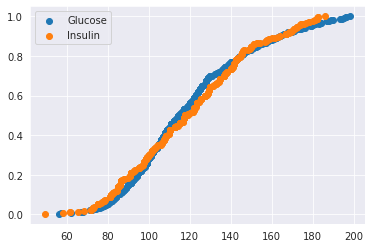

In [35]:
def plot_scatter1(column1 = 'Glucose', column2 = 'Insulin'):
    predict = alpha*test_data[column2]**beta
    plt.scatter(test_data[column1], list(map(lambda point: distr(test_data[column1], point), test_data[column1])), label = column1)
    plt.scatter(predict, list(map(lambda point: distr(predict, point), predict)), label = column2)

plot_scatter1()
plt.legend()

In [39]:
kolmogorov_stat = calculate_Kolmogorov_statistic(test_data['Glucose'], alpha * (test_data['Insulin']**beta))
q_alpha = 0.05   # 5%
D_alpha = np.sqrt(-1/2 * np.log((q_alpha) / 2)) * math.sqrt((len(test_data['Glucose']) + len(test_data['Insulin']))/(len(test_data['Glucose'])*len(test_data['Insulin'])))
print(f"D: {kolmogorov_stat}")
print(f"D_alpha: {D_alpha}")
if kolmogorov_stat < D_alpha:
    print("H0 Confirmed")
else:
    print("H0 Disproved")

D: 0.07267441860465118
D_alpha: 0.10355426975849394
H0 Confirmed


In [9]:
math.sqrt(
    (len(test_data['Glucose']) + len(test_data['Insulin'])) /
    (len(test_data['Glucose']*test_data['Insulin']))
)

344


1.4142135623730951